# Introduction

This is the report for implementing the Fly My Cloud Tensorflow challenge. The document shows some exploratory analysis on the data and how the final solution was selected.

In the following sections the data will be investigated to understand how the user traits and selections are distributed. It will be shown that a simple classification network can fit the data almost perfectly but with poor testing results. Then a very basic ranking of books will be inferred from existing data and a new neural network will be trained on this. It will be shown to (be expected to) achieve a marginal improvement of about 5% in the top 10 hit rate. 


## Notes about the code

Due to time constraints a proper implementation was not possible, since the focus was on trying to improve the network. The shortcomings are as follows:

- There is no error checking, logging, testing etc.
- The variable naming convention is camelCase in tf_rec.py (Java style)

## Loading and basic exploration

We start with the required imports

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

Read and arrange the data from the 2 files. The first column in both cases (the user name) will be the index.

Also create a joined dataset having the *user name* as index, *user traits* on the first 10 columns and *book selection* on the last 1000.

In [4]:
#Read the user features and user preferences dataset; use explicit column range because it gets confused by the trailing comma
usersDF = pd.read_csv("user_char.csv", usecols=range(11), index_col=0)
preferencesDF = pd.read_csv("user_book.csv", usecols=range(1001), index_col=0)
    
#The numbers are assigned integer type, turn them into float32
usersDF = usersDF.astype(np.float32, copy=False)
preferencesDF = preferencesDF.astype(np.float32, copy=False)

#Finally, create the joined dataset. This will not contain the test users (without book selections)
joinDF = usersDF.join(preferencesDF, how='inner')

The next 2 blocks just print the first 5 rows in each dataset

In [5]:
usersDF.iloc[0:5,:]

,chr_1,chr_2,chr_3,chr_4,chr_5,chr_6,chr_7,chr_8,chr_9,chr_10
user_1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
user_2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
user_3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
user_4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
user_5,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [6]:
preferencesDF.iloc[0:5,:]

,book_1,book_2,book_3,book_4,book_5,book_6,book_7,book_8,book_9,book_10,...,book_991,book_992,book_993,book_994,book_995,book_996,book_997,book_998,book_999,book_1000
user_1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
user_2,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
user_3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
user_4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
user_5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


The code below is a glimpse into how often do books get selected. The histogram shows a very tight normal distribution centered at 0.5 with 0.05 standard deviation. In other words, each book tends to be selected by about 50% of the users with roughly 95% of them selected by 40% - 60% of the users (+/- 2 standard deviations).

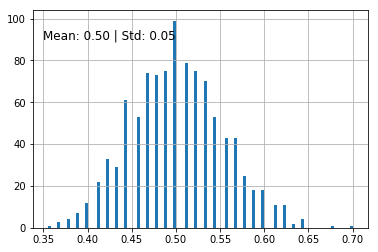

In [7]:
#Mean on each column
means = preferencesDF.mean()

#Plot the histogram with 100 bins
plot = means.hist(bins=100)
plot.text(0.35, 90, "Mean: {:2.2f} | Std: {:2.2f}".format(means.mean(), means.std()), fontsize=12)

Doing the same as above for the user traits. The histogram shows that each trait belongs to 44% - 56% of the users. No particular distribution is visible, however the tight range makes this irrelevant. 

Another way of interpreting this is that each user has roughly 50% of the traits set.

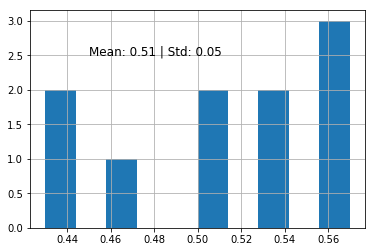

In [8]:
#Mean on each column
means = usersDF.mean()

#Plot the histogram with at most 10 bins
plot = means.hist(bins=10)
plot.text(0.45, 2.5, "Mean: {:2.2f} | Std: {:2.2f}".format(means.mean(), means.std()), fontsize=12)

## Analysis and considerations on the data


The following are a collation of the author's observations and reasoning on the data. They are grouped here just to provide the reader an overview of the thought process without needing to parse the entire document. The following sections will be based on the ideas enumerated here:

- The user/book selection looks a little unusual for a recommendation dataset, which would be expected to be more sparse (more 0 or missing values).


- The users dataset is extremely sparse with 100 datapoints in a 10 dimensional space. This can make many algorithms and especially a neural network able to fit the data easily, however learning the true function (i.e. achieving correct recommendations on unseen data) will be more difficult.


- An important detail is not present in the problem formulation: is 0 an indicator of "user does not like book", or "user has not reviewed book", or both? 


- If the first above is true, we would expect this is a complete dataset and considering the *users with similar traits choose similar books* statement in the problem formulation, would also expect that a neural network should be able to fit the data and predict 0/1 for each book on a test set with reasonable accuracy (though the very sparse dataset might prevent that)


- If 0 also means "user has not reviewed book", such a network would no longer be able to predict 0/1 correctly. This will be shown to be the case.


- The dataset does not contain any explicit ranking. In order to reliably draw the top 10 recommendations, inferring a rank on each user/book selection would be useful. This approach will be detailed in the following sections.

The **recommendation problem** can be approached from 2 ways:

- *Collaborative filtering*, where a user is recommended books based on the similarity between his past choices and other users'. This does not seem to be the approach required by the challenge, although it would be possible in the following way: Sampling 70% of user's choices from the test set, calculating the similarities and recommendations then checking if the top 10 fall into the rest of 30%. This project does not implement such a method.


- *Content based*, where a user is recommended books based on book traits and known preferences of the user for these traits (inferred from past choices or other way). The challenge seems closely related to this approach, although it simplifies things greatly by making the user traits known and the way a book appeals to a certain set of traits also known from the data. The project will try to make use of this.

## Verifying the completeness of the dataset

Preamble: From the data distribution detailed above and the code snipped below show that a random uniform choice of recommendations with 50% probability for 1 and 50% for 0 yields roughly a 50% hit rate. 

In [265]:

#Show the average result for trying to predict randomly the dataset
s = 0
for i in range(1, 10000):
    randoms = joinDF.iloc[:, 10:].sample(n=10, axis=1).sum() / joinDF.shape[0]
    s += randoms.sum()/10
print("Random predictions hit rate: {:.4f}".format((s/10000)))

Random predictions hit rate: 0.5015


If the dataset is complete then using either a simple KNN on the user traits set or a neural network with 10 inputs (user traits) and 1000 outputs (recommendations for each book) trained on a subset of the data would be able to fit the data (the network) and achieve a hit rate >> 50% on the remaining subset.

To verify this, in the following blocks both methods are attempted and shown to fail.

### Attempting KNN

The code below tests the KNN algorithm with 1-20 neighbours, using the sklearn library. The hit rate does not seem to improve even marginally.

In [266]:
#First, split the data randomly into 90% for training and 10% for testing
trainDF = joinDF.sample(frac=0.9)
testDF = joinDF.drop(trainDF.index)

#KNN with K in [1,20] will be attempted
for i in range(1, 21):
    #Create a KNN classifier using sklearn
    knn = KNeighborsClassifier(n_neighbors=i+1)
    
    #Fit the model using training data. Note that the first 10 columns represent user traits (the input) 
    #while the last 1000 represent the outcome
    knn.fit(trainDF.iloc[:,0:10].as_matrix(), trainDF.iloc[:, 10:].as_matrix())
    
    #Use the previously fit model to predict the test data
    pred = knn.predict(testDF.iloc[:,0:10].as_matrix())
    
    #Calculate the number of misses by subtracting the prediction from the truth and counting the non-0 values
    misses = np.count_nonzero(pred - testDF.iloc[:, 10:].as_matrix())    
    
    #Calculate the hit rate
    hitRate = 1 - misses / (testDF.shape[0] * testDF.shape[1] - 10)
    
    print("Using KNN with K={}, Hit Rate={:2.4f} ".format(i+1, hitRate))

Using KNN with K=2, Hit Rate=0.5006 
Using KNN with K=3, Hit Rate=0.5042 
Using KNN with K=4, Hit Rate=0.5057 
Using KNN with K=5, Hit Rate=0.5076 
Using KNN with K=6, Hit Rate=0.5086 
Using KNN with K=7, Hit Rate=0.5126 
Using KNN with K=8, Hit Rate=0.5078 
Using KNN with K=9, Hit Rate=0.5046 
Using KNN with K=10, Hit Rate=0.5091 
Using KNN with K=11, Hit Rate=0.5095 
Using KNN with K=12, Hit Rate=0.5058 
Using KNN with K=13, Hit Rate=0.5036 
Using KNN with K=14, Hit Rate=0.5085 
Using KNN with K=15, Hit Rate=0.5052 
Using KNN with K=16, Hit Rate=0.5088 
Using KNN with K=17, Hit Rate=0.5054 
Using KNN with K=18, Hit Rate=0.5055 
Using KNN with K=19, Hit Rate=0.5076 
Using KNN with K=20, Hit Rate=0.5059 
Using KNN with K=21, Hit Rate=0.5035 


### Attempting a neural network

The notebook will not define and train the network but use the progress data from a pre-trained one, namely *nn/bad1* to show the results. 

This network has 10 inputs, an inner layer of 50 neurons with tanh activation and an output of 1000 neurons with sigmoid activation. Each output corresponds to the book with the same index. A random sample of 90% of the dataset was used for training, the rest for testing. Training is performed for 10,000 epochs with the ADAM optimizer.

The cost function is the cross-entropy considering each output neuron as solving its own classification problem. In other words each output has a cost of:

 E(y) = -(y log(y') + (1-y)log(1-y'))
 
and this is summed over all outputs. The accuracy is evaluated over the entire output (not only the top 10) considering the cutoff point at 0.5. Note that a more proper approach would have included the precision, recall, ROC curve etc. - impossible due to time constraints. 


Below are the plots showing the evolution of the cost and accuracy for both training and testing. It is obvious that although the training parameters evolve towards very good values the testing performance does not improve at any point. The cost (loss) on the test set is actually increasing.

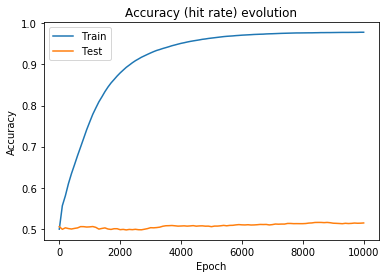

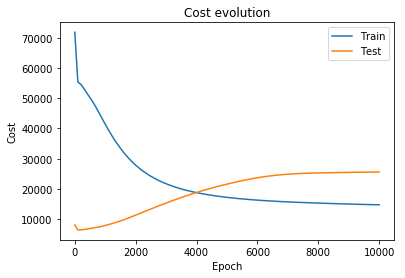

In [267]:
#The file contains 4 columns: train accuracy, train loss, test accuracy, test loss
progress = np.genfromtxt("nn/bad1_progress.txt", delimiter=",", skip_header=1)
epochs = np.arange(0,progress.shape[0]) * 100
plt.plot(epochs, progress[:, 0], epochs, progress[:, 2])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.title("Accuracy (hit rate) evolution")
plt.show()

plt.plot(epochs, progress[:, 1], epochs, progress[:, 3])
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.title("Cost evolution")
plt.show()

## The solution

The previous section shows quite clearly that the dataset is incomplete, i.e. 0 could mean either that the user does not like the book or has not reviewed it yet. Further more, in order to get a reliable top-10 recommendation an overall ranking system for books would need to be taken into account. The next section will take advantage of whatever variance is available in the dataset to rank each book then a neural network trained on this will be shown to improve the performance, albeit not with much.


### Ranking the books

The chosen method is a very simple one and tries to build a relation between each user trait and the books that appeal most to users with users having the trait. The algorithm is as follows:

- Create a new dataframe with the same structure (user traits + book selection) but set the book selection part = 0
- Take each user trait in turn
    - Select only the users that have this trait
        - Calculate the mean selection value of each book
        - Update the new dataframe so that the cell corresponding to each user/book is added this mean value, regardless of wether the user selected the book or not (equivalent to assuming that he has not reviewed it yet)
        

This way we end up with a new dataframe where each user/book pair has a rank value, even if the user did not select that book. 

Note that below, when creating the score, only the first 80 rows are taken into account in score calculation. However, all rows have their value filled.

In [268]:
    #Create a copy of the dataframe
    joinDFAdjusted = joinDF.copy(deep=True)
    
    #Reset the book selection to 0; this will store now the calculated book score for each user
    joinDFAdjusted.iloc[:, 10:] = 0
    
    #For each user trait
    for i in range(10):
        
        #Calculate the mean of each column, taking into account only the rows(users) that have the trait
        means = joinDF.iloc[0:80, :][joinDF.iloc[:, i] == 1].mean()
        
        #The first 10 columns will store the mean of user traits, set them to 0
        means.iloc[0:10] = 0
        
        #Update the new dataset by adding the corresponding mean to each user/book cell
        joinDFAdjusted[joinDFAdjusted.iloc[:, i] == 1] = joinDFAdjusted[joinDFAdjusted.iloc[:, i] == 1].add(means)

    
    #Normalize the output of the new dataset to mean = 0 and stddev = 1 (effectively subtract the mean and divide by stddev)
    joinDFAdjusted.iloc[:, 10:] = (joinDFAdjusted.iloc[:, 10:] - joinDFAdjusted.iloc[:, 10:].mean()) / joinDFAdjusted.iloc[:, 10:].std()

    #Show the first 5 rows, just to verify: the user traits are unaltered while the user/books value now store a score-like value
    joinDFAdjusted.iloc[:5,:]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,chr_1,chr_2,chr_3,chr_4,chr_5,chr_6,chr_7,chr_8,chr_9,chr_10,...,book_991,book_992,book_993,book_994,book_995,book_996,book_997,book_998,book_999,book_1000
user_1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.151913,1.287735,1.367413,1.242221,1.018688,1.128886,1.113942,1.337826,1.246644,1.083562
user_2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.784949,-0.503826,-0.781353,-0.779423,-0.856414,-0.793172,-0.836646,-0.614164,-0.685745,-0.776835
user_3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,-0.738497,-0.763734,-0.734168,-0.862505,-0.709930,-0.662705,-0.789088,-0.807932,-0.699018,-0.712449
user_4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.501851,0.435225,0.458569,0.550386,0.597230,0.517731,0.610924,0.305631,0.403493,0.637034
user_5,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.501851,0.618538,0.548043,0.519088,0.514551,0.456368,0.399415,0.434494,0.504583,0.637034


### Implementing a trivial recommender


The algorithm is extremely simple. Since the ranking dataset is pre-filled, we only take the top 10 user/book values from each row and look if the user actually selected them in the original dataset.

This works just for testing on the available data. Adding new rows will require filling the corresponding cells with the score values (without taking their own user traits into account).

As the next output below shows, the performance is **80% hit rate overall and 47% hit rate on unseen data**. The *tf_rec* script used in *build* mode shows the performance on more than one data folds.

In [269]:
#This is the test set - the last 10 users, which have not been included when creating the model
testDF = joinDF.iloc[80:, :]

#Initialize the test and overall hit rate accumulators
testHR = 0
allHR = 0

#For each record in the dataset
for i in range(joinDFAdjusted.shape[0]):
    
    #Select only the user/book cells
    series = joinDFAdjusted.iloc[i, 10:]
    
    #Get the 10 largest values and their indices. 
    largest = series.nlargest(10)
    
    #Now take the determined indices and look in the original dataset (having 0/1 instead of score)
    #Hopefully for each index the user will have really selected the book
    #Calculate that by summing all the corresponding values and dividing by 10 (1 = full hit, 0 = no hit)
    sum = joinDF.loc[series.name, largest.index].sum() / 10
    
    #Update the overall hit rate accumulator
    allHR += sum
    
    #Update the test hit rate accumulator only if this column exists in the test set
    if series.name in testDF.index:
        testHR += sum
    pass

print("HR on all / test: {:.2f} / {:.2f}".format(allHR/joinDF.shape[0], testHR/testDF.shape[0]))


HR on all / test: 0.80 / 0.47


### Implementing a neural network

The network structure, training method and epochs were determined using a deviation of *cross validation*: 
- A validation dataset of 9 rows was randomly selected
- The remaining dataset was split in 10 folds
- 10 networks were fit on different combinations of 9 folds each, leaving the 10-th as test set
- The network with the best result on the test set was selected
- The selected network was also tested on the validation dataset. If the results were good (>50%), the network was saved as the final solution

A different number of layers and neurons were tested. The configurations with 1 inner layer and very small number of neurons, trained for large number of epochs with very low learning rate proved to be the most stable. The reason might be a tendency to underfit the data combined with a higher chance to follow the true function behind the data. Other configurations such as: 2 X 1000 neurons, dropout on the inner layers etc. would show a higher variance in the test performance so were deemed unreliable.

Numerous experiments were performed, and the performance was between 50% - 55% hit rate on the test set with about 52.5% average. This shows only a marginal performance improvement (5%).

The network structure is as follows:

- 10 inputs (the user traits)
- 1 inner layers X 8 neurons, tanh activation
- 1000 neurons output, identity activation
- Sum of squared differences as loss function (since the problem is a regression now)
- L2 regularization set to 0.1
- ADAM optimizer with 7E-5 learning rate
- 20000 training steps


## Conclusions

The chosen solution seems to improve the base 50% hit rate, if only very slightly. Other options might provide a more reliable improvement, such as:

- Using matrix factorization on the user/book dataset to extract more features (of books)
- Trying a Neural Collaborative Filtering network, as described by [He et al.]: https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
- Trying other neural net-based method, as surveyed by [Zhang et al.] https://arxiv.org/pdf/1707.07435.pdf
- An ensamble of neural networks built from the K-fold validation by selecting the n-most promising and averaging their results. Note this could be implemented as a single 3D network sharing the inputs and trained separately on each depth dimension.